![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score


In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')
test= pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')


# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
#Métricas para poder comparar los modelos al final
MAE = {}
RMSE = {}
R2 = {}
MAPE = {}

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [7]:
# Celda 1
#La clase DecisionNode se utiliza para representar cada nodo en el árbol de decisión
class DecisionNode:
    def __init__(self, feature=None, threshold=None, value=None, left_branch=None, right_branch=None):
        self.feature = feature
        self.threshold = threshold
        self.value = value
        self.left_branch = left_branch
        self.right_branch = right_branch



#Calcular la entropía para cada nodo del árbol, (La entropía es una medida de la impureza de un conjunto de datos)
def entropy(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    entropy = 0
    for prob in probabilities:
        if prob > 0:
            entropy += -prob * np.log2(prob)
    return entropy



#Función permitirá dividir los datos en función de una característica específica (la estación o la hora del día)
def split_data(X, y, feature, threshold):
    left_indices = X[:, feature] < threshold
    right_indices = ~left_indices
    X_left = X[left_indices]
    X_right = X[right_indices]
    y_left = y[left_indices]
    y_right = y[right_indices]
    return X_left, X_right, y_left, y_right

#función principal para construir el árbol de decisión
def build_tree(X, y, depth=0, max_depth=5):
    num_samples, num_features = X.shape
    best_feature, best_threshold, best_gain = None, None, 0
    for feature in range(num_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_X, right_X, left_y, right_y = split_data(X, y, feature, threshold)
            if len(left_y) > 0 and len(right_y) > 0:
                gain = entropy(y) - (len(left_y) / num_samples) * entropy(left_y) - (len(right_y) / num_samples) * entropy(right_y)
                if gain > best_gain:
                    best_feature = feature
                    best_threshold = threshold
                    best_gain = gain
    if best_gain > 0 and depth < max_depth:
        left_X, right_X, left_y, right_y = split_data(X, y, best_feature, best_threshold)
        print(f"At depth {depth}, we split on feature {best_feature} with gain {best_gain:.2f} and threshold {best_threshold:.2f}")
        left_branch = build_tree(left_X, left_y, depth+1, max_depth)
        right_branch = build_tree(right_X, right_y, depth+1, max_depth)
        return DecisionNode(feature=best_feature, threshold=best_threshold, left_branch=left_branch, right_branch=right_branch)
    else:
        leaf_value = np.mean(y)
        print(f"At depth {depth}, we have a leaf node with value {leaf_value:.2f}")
        return DecisionNode(value=leaf_value)

#profundidad de 5 nodos
tree = build_tree(X_train.to_numpy(), y_train.to_numpy(), max_depth=5)

#La función predict toma como entrada un conjunto de datos de prueba X_test y devuelve una lista de predicciones para cada elemento en X_test
def predict(node, x):
    if node.value is not None:
        return node.value
    feature_value = x[node.feature]
    if feature_value <= node.threshold:
        return predict(node.left_branch, x)
    else:
        return predict(node.right_branch, x)

y_pred = []
for x in X_test.to_numpy():
    y_pred.append(predict(tree, x))


At depth 0, we split on feature 0 with gain 0.72 and threshold 2014.00
At depth 1, we split on feature 0 with gain 0.70 and threshold 2012.00
At depth 2, we split on feature 0 with gain 0.58 and threshold 2010.00
At depth 3, we split on feature 1 with gain 0.58 and threshold 101185.00
At depth 4, we split on feature 1 with gain 0.65 and threshold 82369.00
At depth 5, we have a leaf node with value 9360.24
At depth 5, we have a leaf node with value 8352.55
At depth 4, we split on feature 0 with gain 0.58 and threshold 2008.00
At depth 5, we have a leaf node with value 6945.17
At depth 5, we have a leaf node with value 7740.95
At depth 3, we split on feature 1 with gain 0.71 and threshold 89857.00
At depth 4, we split on feature 1 with gain 0.75 and threshold 63429.00
At depth 5, we have a leaf node with value 11866.64
At depth 5, we have a leaf node with value 10738.05
At depth 4, we split on feature 1 with gain 0.75 and threshold 114286.00
At depth 5, we have a leaf node with value 981

In [8]:
#Métricas
#MAE (error absoluto medio): Es el promedio de la diferencia absoluta entre el valor observado y los valores predichos (debe acercarse a 0)
MAE_Arbman = mean_absolute_error(y_test, y_pred)
#Arreglo para acumular las medidas para comparar al final
MAE['Arbol decisión manual'] = MAE_Arbman
print('MAE:',MAE_Arbman)

#RMSE devuelve la fiabilidad del modelo
RMSE_Arbman = np.sqrt(mean_squared_error(y_test, y_pred))
#Arreglo para acumular las medidas para comparar al final
RMSE['Arbol decisión manual'] = RMSE_Arbman
print('RMSE:',RMSE_Arbman)

#Otras métricas
# calcular R cuadrado -> calidad del ajuste del modelo a los datos observados
R2_Arbman = r2_score(y_test, y_pred)
#Arreglo para acumular las medidas para comparar al final
R2['Arbol decisión manual'] = R2_Arbman
# imprimir los resultados
print('R2:',R2_Arbman)

# calcular MAPE Error Porcentual Absoluto Medio ->se expresa como un porcentaje, y cuanto más cercano a cero sea el valor del MAPE, mayor será la precisión del modelo de predicción
MAPE_Arbman = np.mean(np.abs((y_test - y_pred)/y_test))*100
#Arreglo para acumular las medidas para comparar al final
MAPE['Arbol decisión manual'] = MAPE_Arbman
# imprimir los resultados
print('MAPE:',MAPE_Arbman)


MAE: 1448.9946457605197
RMSE: 1970.0280485614176
R2: 0.7462752665964936
MAPE: 9.978526888607526


## Observaciones Árbol de decisión manual
- El **MAE (Error Absoluto Medio)** es una medida de la diferencia entre los valores reales y los valores predichos. En este caso, el valor del MAE es de 1448.99, lo que indica que en promedio, **las predicciones difieren de los valores reales en 1448.99 unidades de la variable Price**

- El **RMSE (Error Cuadrático Medio)** es otra medida de la diferencia entre los valores reales y los valores predichos, pero está más influenciado por valores atípicos en los datos. En este caso, el valor del RMSE es de 1970.02, lo que significa que la raíz cuadrada del **promedio de los errores al cuadrado es de 1970.02 unidades de la variable Price**

- **R2:** es el coeficiente de determinación y representa la proporción de la varianza en la variable objetivo que es explicada por el modelo. **Un valor de 0.746 indica que el modelo explica el 74.6% de la varianza en la variable objetivo**

- **MAPE (Mean Absolute Percentage Error)** es el error porcentual promedio de las predicciones del modelo. **Un valor de 9.97% significa que, en promedio, el modelo se desvía en un 9.97% de la variable objetivo**

En general, estos resultados sugieren que **el modelo de Árbol de decisión manual puede ser útil para predecir la variable Price**, pero aún existen errores significativos en las predicciones, lo siguiente es compararlo con los demás modelos para saber su rendimiento

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [9]:
# Celda 2

trees = []

#10 árboles 
for i in range(10):
    random_indices = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
    

    tree = DecisionTreeRegressor()

    #Entrenar 10 árboles de regresión sobre cada subconjunto de entrenamiento
    tree.fit(X_train.iloc[random_indices], y_train.iloc[random_indices])
    trees.append(tree)

# Hacemos la predicción con nuestro modelo bagging manual
y_pred = np.zeros(len(X_test))
for tree in trees:
    y_pred += tree.predict(X_test)


y_pred /= len(trees)


In [10]:
#Métricas
#MAE (error absoluto medio): Es el promedio de la diferencia absoluta entre el valor observado y los valores predichos (debe acercarse a 0)
MAE_Bagman = mean_absolute_error(y_test, y_pred)
#Arreglo para acumular las medidas para comparar al final
MAE['Bagging manual'] = MAE_Bagman
print('MAE:',MAE_Bagman)

#RMSE devuelve la fiabilidad del modelo
RMSE_Bagman = np.sqrt(mean_squared_error(y_test, y_pred))
#Arreglo para acumular las medidas para comparar al final
RMSE['Bagging manual'] = RMSE_Bagman
print('RMSE:',RMSE_Bagman)

# calcular R cuadrado -> calidad del ajuste del modelo a los datos observados
R2_Bagman = r2_score(y_test, y_pred)
#Arreglo para acumular las medidas para comparar al final
R2['Bagging manual'] = R2_Bagman
# imprimir los resultados
print('R2:',R2_Bagman)

# calcular MAPE Error Porcentual Absoluto Medio ->se expresa como un porcentaje, y cuanto más cercano a cero sea el valor del MAPE, mayor será la precisión del modelo de predicción
MAPE_Bagman = np.mean(np.abs((y_test - y_pred)/y_test))*100
#Arreglo para acumular las medidas para comparar al final
MAPE['Bagging manual'] = MAPE_Bagman
# imprimir los resultados
print('MAPE:',MAPE_Bagman)


MAE: 1345.5682205061587
RMSE: 1811.1568170127327
R2: 0.7855480026595157
MAPE: 9.770290991368299


## Observaciones Bagging manual

- El **Mean Absolutive Error (MAE)** del modelo Bagging (Manual), significa que en **promedio las predicciones del modelo difieren del valor real en 1345.56**. Si este valor disminuye significa que el modelo mejora su precisión

- El **Root Squared Error (RMSE)** es una métrica parecida al MAE, en **promedio las predicciones del modelo varian en 1811.15 con respecto al valor real**. Para saber si este RMSE es bueno, debemos compararlo con el resultado de otros modelos, ejercicio que se realizará en puntos posteriores de este taller

- **R2** obtenido permite pensar que es un buen modelo, al **explicar el 78.55% de los datos** de acuerdo al resultados del R2 (0.7855). Y que existe un 21,45% de los datos que el modelo no explica.

- El Error Porcentual Absoluto Medio por sus siglas en inglés **MAPE (Mean Absolute Percentage Error), tiene un valor de 9.77%**, es decir que en este porcentaje su pronósitco varia por encima o por debajo del valor real

En conclusión el **modelo tiene un buen desempeño**, sin embargo entre el MAE y RMSE se presenta una leve diferencia entre ellos, con respecto en cuanto difieren a las predicciones frente al valor real. A su vez las métricas R2 y MAPE presentan resultados que permite inferir que el modelo tiene un buen desempeño. El R2 esta muy cerca al 80%, que se considera en términos generales muy bueno y la última métrica - MAPE se encuentra por debajo del 10%, siendo un valor manejable al momento de predecir.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [11]:
# Celda 3


#n_estimators es la cantidad de árboles a contruir dentro del bosque aleatorio.
#max_features es el número de variables que se deben considerar en cada árbol, en este caso me dan dos, es decir, que cada árbol 

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

#¡ que me dice el max_features?

def bagging (num_arboles,num_var):

#Modelo
  bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators= num_arboles, max_features=num_var,
                           bootstrap=True, oob_score=True, random_state=1)
  

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
  bagreg.fit(X_train, y_train)
  y_predbag = bagreg.predict(X_test)

  #Métricas
  #MAE (error absoluto medio): Es el promedio de la diferencia absoluta entre el valor observado y los valores predichos (debe acercarse a 0)
  MAE_Bag = mean_absolute_error(y_test, y_predbag)
  #Arreglo para acumular las medidas para comparar al final
  MAE['Bagging'] = MAE_Bag
  print('MAE:',MAE_Bag)

  #RMSE devuelve la fiabilidad del modelo
  RMSE_Bag = np.sqrt(mean_squared_error(y_test, y_predbag))
  #Arreglo para acumular las medidas para comparar al final
  RMSE['Bagging'] = RMSE_Bag
  print('RMSE:',RMSE_Bag)

  # calcular R cuadrado -> calidad del ajuste del modelo a los datos observados
  R2_Bag = r2_score(y_test, y_predbag)
  #Arreglo para acumular las medidas para comparar al final
  R2['Bagging'] = R2_Bag
  # imprimir los resultados
  print('R2:',R2_Bag)

  # calcular MAPE Error Porcentual Absoluto Medio ->se expresa como un porcentaje, y cuanto más cercano a cero sea el valor del MAPE, mayor será la precisión del modelo de predicción
  MAPE_Bag = np.mean(np.abs((y_test - y_predbag)/y_test))*100
  #Arreglo para acumular las medidas para comparar al final
  MAPE['Bagging'] = MAPE_Bag
  # imprimir los resultados
  print('MAPE:',MAPE_Bag)


In [12]:
bagging(10,np.log(X_train.shape[1]).astype(int))

MAE: 2074.9760882251453
RMSE: 2671.0127988157697
R2: 0.5335877762675875
MAPE: 17.330953043196025


##  Observaciones Bagging con librería

- Para el modelo con 10 arboles y 2 variables a considerar en cada árbol se obtuvó: 

  Un **MAE de 2.074**,es decir, que en promedio el modelo va a predecir el precio con una diferencia de 2.047 sobre el real. 

  Un **RMSE de 2.671**, un valor alto en comparación con el modelo del árbol de decisión manual (1970) y el modelo bagging manual (1.794), por lo que podemos afirmar que este modelo no es mejor que los anteriores. 

  Un **r2 de tan solo el 53.3%**, es decir, que los modelos en el ensamblado no se estan ajustando muy bien a los datos. 

  Un **MAPE de 17,3%**, es decir, que el modelo va a predecir el precio con una diferencia proporcional sobre el precio real del 17%, bien sea por encima o por debajo. 

En conclusión , estos resultados sugieren que el modelo dE Bagging con librería con 10 árboles y 2 variables a considerar en cada árbol no es el mejor modelo para predecir el precio en cuestión y se debería explorar otras alternativas de modelado para mejorar el rendimiento del modelo



### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [13]:
# Celda 4
# dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# crear una instancia del modelo de bosque aleatorio
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# entrenar el modelo en los datos de entrenamiento
rf.fit(X_train, y_train)

# hacer predicciones en los datos de prueba
y_predrf = rf.predict(X_test)

In [14]:
#Métricas
#MAE (error absoluto medio): Es el promedio de la diferencia absoluta entre el valor observado y los valores predichos (debe acercarse a 0)
MAE_RF = mean_absolute_error(y_test, y_predrf)
#Arreglo para acumular las medidas para comparar al final
MAE['Random forest'] = MAE_RF
print('MAE:',MAE_RF)

#RMSE devuelve la fiabilidad del modelo
RMSE_RF = np.sqrt(mean_squared_error(y_test, y_predrf))
#Arreglo para acumular las medidas para comparar al final
RMSE['Random forest'] = RMSE_RF
print('RMSE:',RMSE_RF)

# calcular R cuadrado -> calidad del ajuste del modelo a los datos observados
R2_RF = r2_score(y_test, y_predrf)
#Arreglo para acumular las medidas para comparar al final
R2['Random forest'] = R2_RF
# imprimir los resultados
print('R2:',R2_RF)

# calcular MAPE Error Porcentual Absoluto Medio ->se expresa como un porcentaje, y cuanto más cercano a cero sea el valor del MAPE, mayor será la precisión del modelo de predicción
MAPE_RF = np.mean(np.abs((y_test - y_pred)/y_test))*100
#Arreglo para acumular las medidas para comparar al final
MAPE['Random forest'] = MAPE_RF
# imprimir los resultados
print('MAPE:',MAPE_RF)


MAE: 1314.4207078056425
RMSE: 1765.4118259983413
R2: 0.7962441677396794
MAPE: 9.770290991368299


## Observaciones Random forest con librería
 
- Los resultados obtenidos con el modelo **Random Forest muestran que la precisión de las predicciones es mejor en comparación con los modelos anteriores**. Esto se puede observar en la métrica MAE y RMSE, las cuales tienen valores menores en el *modelo Random Forest (1314.42 y 1765.41, respectivamente)* en comparación con los demás modelos. Además, el **valor de R cuadrado en el modelo Random Forest (0.7962)** también es mayor que en los demás modelos, lo que indica que el modelo Random Forest tiene una mayor capacidad de explicar la variable Price

- **MAPE (Mean Absolute Percentage Error): es el error porcentual promedio de las predicciones del modelo. Un valor de 9.77%** significa que, en promedio, el modelo se desvía en un 9.77% de la variable objetivo

En resumen, el **modelo Random Forest parece ser una opción más precisa** y efectiva para predecir la variable Price en comparación con los demás modelos, continuamos en los siguientes puntos para al final revisar cual es el mejor modelo

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Text(0, 0.5, 'R2')

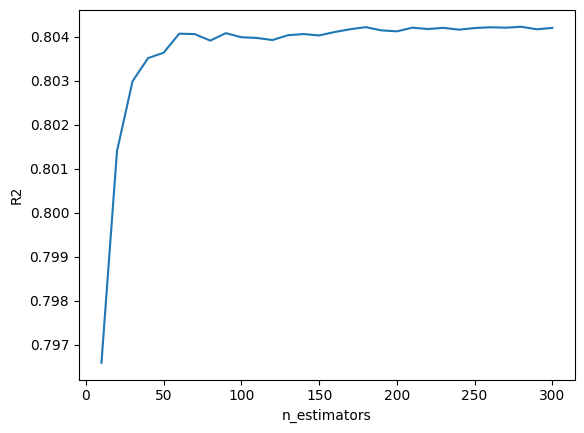

In [15]:
# ==============================================================================
#CALIBRACIÓN DEL PARÁMETRO N_ESTIMATORS: 

#n_estimators: es la cantidad de árboles a contruir dentro del bosque aleatorio.


from sklearn.model_selection import cross_val_score

estimator_range = range(10, 310, 10)
# Definición de lista para almacenar la metrica para cada valor de n_estimators
R2_scores = []


# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    clf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    R2_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='r2').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, R2_scores)
plt.xlabel('n_estimators')
plt.ylabel('R2')

In [16]:
from sklearn.metrics import get_scorer_names
print(get_scorer_names())

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

Text(0, 0.5, 'r2')

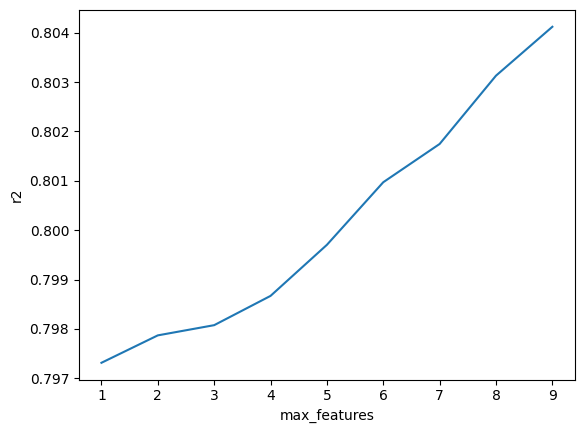

In [17]:
# ==============================================================================
#CALIBRACIÓN DEL PARÁMETRO max_features : 

#max_features es el número de variables que se deben considerar en cada árbol.


from sklearn.model_selection import cross_val_score

# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(X_train.columns)+1)

# Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
R2_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    R2_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='r2').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(feature_range, R2_scores)
plt.xlabel('max_features')
plt.ylabel('r2')

Text(0, 0.5, 'r2')

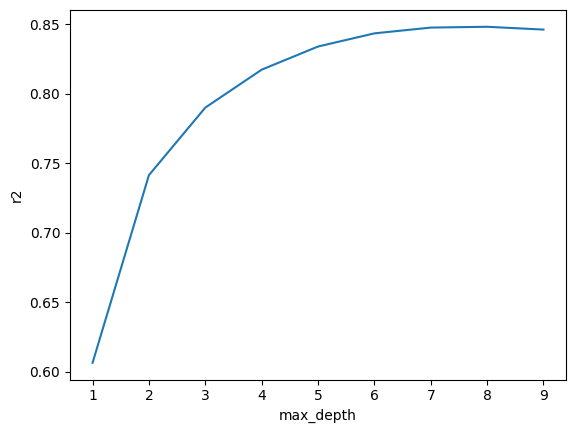

In [18]:
# ==============================================================================
#CALIBRACIÓN DEL PARÁMETRO max_depth: 

#max_depth: profundidad máxima que pueden alcanzar los árboles 


from sklearn.model_selection import cross_val_score

# Creación de lista de valores para iterar sobre diferentes valores de max_features
depth_range = range(1, len(X_train.columns)+1)

# Definición de lista para almacenar metrica
R2_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for depth in depth_range:
    clf = RandomForestRegressor(n_estimators=200, max_features=9, random_state=1, n_jobs=-1, max_depth=depth)
    R2_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='r2').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(feature_range, R2_scores)
plt.xlabel('max_depth')
plt.ylabel('r2')

## Random Forest con calibración de parámetros

In [19]:
# crear una instancia del modelo de bosque aleatorio
rf_calibrado = RandomForestRegressor(n_estimators=200, max_features=9, random_state=1, n_jobs=-1, max_depth=6)

# entrenar el modelo en los datos de entrenamiento
rf_calibrado.fit(X_train, y_train)

# hacer predicciones en los datos de prueba
y_predrf_cal = rf_calibrado.predict(X_test)

#Métricas
#MAE (error absoluto medio): Es el promedio de la diferencia absoluta entre el valor observado y los valores predichos (debe acercarse a 0)
MAE_RFCal = mean_absolute_error(y_test, y_predrf_cal)
#Arreglo para acumular las medidas para comparar al final
MAE['Random forest Cal'] = MAE_RFCal
print('MAE:',MAE_RFCal)

#RMSE devuelve la fiabilidad del modelo
RMSE_RFCal = np.sqrt(mean_squared_error(y_test, y_predrf_cal))
#Arreglo para acumular las medidas para comparar al final
RMSE['Random forest Cal'] = RMSE_RFCal
print('RMSE:',RMSE_RFCal)

# calcular R cuadrado -> calidad del ajuste del modelo a los datos observados
R2_RFCal = r2_score(y_test, y_predrf_cal)
#Arreglo para acumular las medidas para comparar al final
R2['Random forest Cal'] = R2_RFCal
# imprimir los resultados
print('R2:',R2_RFCal)

# calcular MAPE Error Porcentual Absoluto Medio ->se expresa como un porcentaje, y cuanto más cercano a cero sea el valor del MAPE, mayor será la precisión del modelo de predicción
MAPE_RFCal = np.mean(np.abs((y_test - y_predrf_cal)/y_test))*100
#Arreglo para acumular las medidas para comparar al final
MAPE['Random forest Cal'] = MAPE_RFCal
# imprimir los resultados
print('MAPE:',MAPE_RFCal)


MAE: 1166.2816146808436
RMSE: 1578.8524008869194
R2: 0.837032482668316
MAPE: 8.480185922598945


## Observaciones Calibración de parámetros Random forest

Al realizar la calibración de los parámetros y obteniendo: 

max_features: 200,max_depth: 6 y un n_estimator:200, mejora en todas las métricas al random forest realizado en el punto 4 sin calibrar. 

**Métricas calibradas**

MAE: 1166.28

RMSE: 1578.85

R2: 0.8370

MAPE: 8.48

**Métricas sin calibrar**

MAE: 1314.42

RMSE: 1765.41

R2: 0.7962

MAPE: 9.78



En conclusión, es mejor calibrar los parámetros del modelo para obtener mejores predicciones

### Descripción de parámetros:

- *max_features*: se refiere al número máximo de características que se consideran al buscar la mejor división en cada árbol de decisión en el bosque aleatorio. En este caso, se ha establecido en 200, lo que significa que se considerarán hasta 200 características para la construcción de cada árbol.

- *max_depth*: indica la profundidad máxima de cada árbol de decisión en el bosque aleatorio. En este caso, se ha establecido en 6, lo que significa que cada árbol tendrá como máximo 6 niveles de profundidad.

- *n_estimators*: se refiere al número de árboles de decisión que se construirán en el bosque aleatorio. En este caso, se ha establecido en 200, lo que significa que se construirán 200 árboles de decisión para formar el bosque aleatorio.


### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [20]:
# Celda 6c
XGBCclf = xgb.XGBRegressor()
XGBCclf.fit(X_train, y_train)
y_predxgb = XGBCclf.predict(X_test)

In [21]:
#Métricas
#MAE (error absoluto medio): Es el promedio de la diferencia absoluta entre el valor observado y los valores predichos (debe acercarse a 0)
MAE_XGB = mean_absolute_error(y_test, y_predxgb)
#Arreglo para acumular las medidas para comparar al final
MAE['XGBoost'] = MAE_XGB
print('MAE:',MAE_XGB)

#RMSE devuelve la fiabilidad del modelo
RMSE_RFXGB = np.sqrt(mean_squared_error(y_test, y_predxgb))
#Arreglo para acumular las medidas para comparar al final
RMSE['XGBoost'] = RMSE_RFXGB
print('RMSE:',RMSE_RFXGB)

# calcular R cuadrado -> calidad del ajuste del modelo a los datos observados
R2_RFXGB = r2_score(y_test, y_predxgb)
#Arreglo para acumular las medidas para comparar al final
R2['XGBoost'] = R2_RFXGB
# imprimir los resultados
print('R2:',R2_RFXGB)

# calcular MAPE Error Porcentual Absoluto Medio ->se expresa como un porcentaje, y cuanto más cercano a cero sea el valor del MAPE, mayor será la precisión del modelo de predicción
MAPE_RFXGB = np.mean(np.abs((y_test - y_predxgb)/y_test))*100
#Arreglo para acumular las medidas para comparar al final
MAPE['XGBoost'] = MAPE_RFXGB
# imprimir los resultados
print('MAPE:',MAPE_RFXGB)


MAE: 1186.634392366123
RMSE: 1621.4197004256812
R2: 0.8281265175296673
MAPE: 8.648872393314539


## Observaciones XGBoost con librería

- Los resultados obtenidos con el modelo **XGBoost** muestran que la precisión de las predicciones son mejores en comparación con los modelos anteriores. Esto se puede observar en la métrica MAE y RMSE, las cuales tienen valores menores a los modelos de Bagging y RandomForest.

-   El **valor de R cuadrado este modelo (0.84)** lo cual es coherente con las conclusiones de las medidas anteriores, de hecho es muy cercano al algoritmo de Random Forest. 

- **MAPE (Mean Absolute Percentage Error)**: es el error porcentual promedio de las predicciones del modelo. Un valor de **8.22% significa que, en promedio, el modelo se desvía en un 8.22% de la variable objetivo**

En conclusión, el modelo **XGBoost** es, hasta ahora, la mejor opción con mejor rendimiento y precision que los modelos anteriormente evaluados. 

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Text(0, 0.5, 'r2')

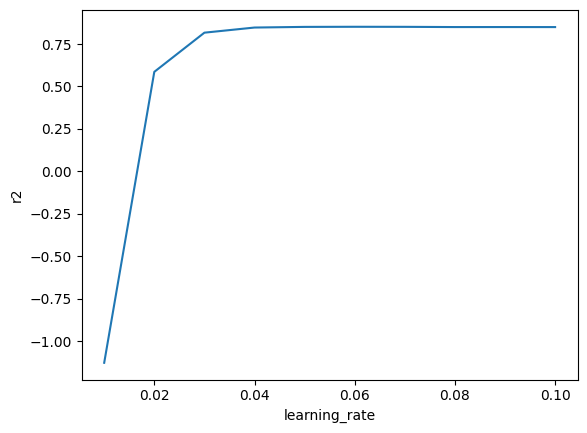

In [22]:

from sklearn.model_selection import cross_val_score

# Creación de lista de valores para iterar sobre diferentes valores de learning rate
lr_lista = [i/100 for i in range(1,11)]

# Definición de lista para almacenar metrica
R2_scores = []

for lr in lr_lista:
    clf = xgb.XGBRegressor(learning_rate=lr)
    R2_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='r2').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(lr_lista, R2_scores)
plt.xlabel('learning_rate')
plt.ylabel('r2')

Text(0, 0.5, 'r2')

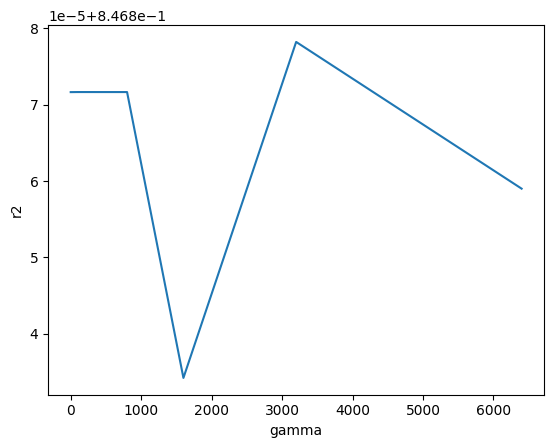

In [23]:
# Definición de lista para almacenar metrica
R2_scores = []

gamma_list=[0,10,100,200,400,800,1600,3200, 6400]
# Uso de un 5-fold cross-validation para cada valor de max_features
for gam in gamma_list:
    clf = xgb.XGBRegressor(learning_rate=0.04, gamma=gam)
    R2_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='r2').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(gamma_list, R2_scores)
plt.xlabel('gamma')
plt.ylabel('r2')

Text(0, 0.5, 'r2')

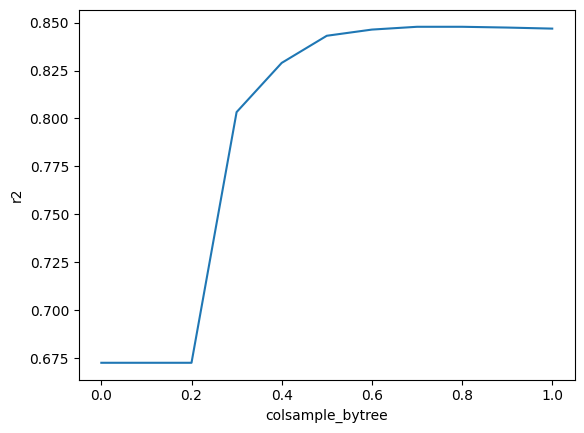

In [24]:
# Definición de lista para almacenar metrica
R2_scores = []
cols_lista = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

# Uso de un 5-fold cross-validation para cada valor de max_features
for cols in cols_lista:
    clf = xgb.XGBRegressor(learning_rate=0.04, gamma=0, colsample_bytree=cols)
    R2_scores.append(cross_val_score(clf, X_train, y_train, cv=5, scoring='r2').mean())

# Gráfica del desempeño del modelo vs la cantidad de n_estimators
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(cols_lista, R2_scores)
plt.xlabel('colsample_bytree')
plt.ylabel('r2')

In [25]:
XGBCclfcal = xgb.XGBRegressor(learning_rate=0.04, gamma=0, colsample_bytree=0.7)
XGBCclfcal.fit(X_train, y_train)
y_predxgbcal = XGBCclfcal.predict(X_test)

In [26]:
#Métricas
#MAE (error absoluto medio): Es el promedio de la diferencia absoluta entre el valor observado y los valores predichos (debe acercarse a 0)
MAE_XGB_CAL = mean_absolute_error(y_test, y_predxgbcal)
#Arreglo para acumular las medidas para comparar al final
MAE['XGBoost Calibrado'] = MAE_XGB_CAL
print('MAE:',MAE_XGB_CAL)

#RMSE devuelve la fiabilidad del modelo
RMSE_RFXGB_CAL = np.sqrt(mean_squared_error(y_test, y_predxgbcal))
#Arreglo para acumular las medidas para comparar al final
RMSE['XGBoost Calibrado'] = RMSE_RFXGB_CAL
print('RMSE:',RMSE_RFXGB_CAL)

# calcular R cuadrado -> calidad del ajuste del modelo a los datos observados
R2_RFXGB_CAL = r2_score(y_test, y_predxgbcal)
#Arreglo para acumular las medidas para comparar al final
R2['XGBoost Calibrado'] = R2_RFXGB_CAL
# imprimir los resultados
print('R2:',R2_RFXGB_CAL)

# calcular MAPE Error Porcentual Absoluto Medio ->se expresa como un porcentaje, y cuanto más cercano a cero sea el valor del MAPE, mayor será la precisión del modelo de predicción
MAPE_RFXGB_CAL = np.mean(np.abs((y_test - y_predxgbcal)/y_test))*100
#Arreglo para acumular las medidas para comparar al final
MAPE['XGBoost Calibrado'] = MAPE_RFXGB_CAL
# imprimir los resultados
print('MAPE:',MAPE_RFXGB_CAL)


MAE: 1140.4511514359754
RMSE: 1566.116699922799
R2: 0.839651010666472
MAPE: 8.130377177520137


## Observaciones Calibración de parámetros XGBoost

- Se realiza la calibración de los parámetros y obteniendo: 

Learning rate: 0.04, gamma: 0 y un colsample_bytree:0.7, no mejora las metricas del XGBoost sin calibrar. 

**Métricas calibradas**
- MAE: 1140.45
- RMSE: 1566.11
- R2: 0.8396
- MAPE: 8.13

**Métricas sin calibrar**
- MAE: 1186.63
- RMSE: 1621.41
- R2: 0.8281
- MAPE: 8.64


En conclusión, si mejora el desempeño del modelo al predecir el precio , cuando se calibran los parámetros. 

###Descripción de parámetros: 
- *learning_rate*: es el parametro que especifica qué tan rápido el modelo debería actualizar sus predicciones y pesos en respuesta a los errores durante el proceso de entrenamiento. Un learning_rate más bajo puede ayudar a prevenir el sobreajuste y a obtener mejores resultados de generalización, pero también puede aumentar el tiempo de entrenamiento del modelo. Por otro lado, un learning_rate más alto puede llevar a un entrenamiento más rápido, pero también puede aumentar el riesgo de sobreajuste. En este caso se puede observar en la gráfica que para el aumento del learning rate aumenta de forma importante el despempeño del modelo hasta el punto en el que se estanca. 

- *Gamma*: el parámetro de regularización que controla la complejidad del modelo. Un valor más alto reduce la complejidad del modelo y disminuye el riesgo de sobreajuste. Para este caso se observa que no parece afectar el desempeño del modelo. Esto se puede deber a que el modelo no es lo suficientemente complejo. 

- *colsample_bytree*: es el parametro que marca la proporción de columnas que se utilizarán en cada árbol. Un valor más bajo reduce la complejidad del modelo y disminuye el riesgo de sobreajuste.Para este caso se puede observar que el r2 del modelo aumenta hasta llegar a 0.7 donde el cambio se vuelve muy pequeño. 

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

#Observaciones comparación de modelos

Comparación del MAE(error absoluto medio): Es el promedio de la diferencia absoluta entre el valor observado y los valores predichos (debe acercarse a 0)

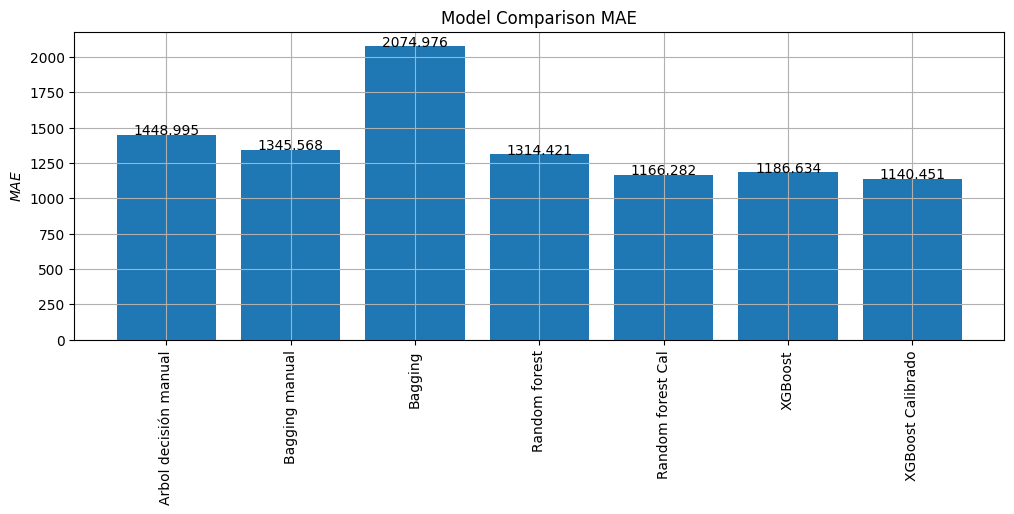

In [33]:
# Celda 8

import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.bar(MAE.keys(),MAE.values() )
plt.ylabel('$MAE$')
plt.title('Model Comparison MAE')
plt.grid()
  
def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+ 0.002, round(y[i],3), ha = 'center')
        plt.xticks(rotation=90)

add_labels(MAE.keys(),list(MAE.values())) 

Al comparar todos los modelos, El **XG Boost calibrado es el modelo con el MAE más bajo**, es decir, con el mejor desempeño, teniendo en cuenta que en promedio el **modelo solo va a tener un error de 1140 al predecir el precio** 

Al comparar los modelos de Random Forest y XG Boost se puede evidenciar que mejora el desempeño de los mismos al calibrar los parámetros. 








##Comparación del RMSE(Error de la raíz cuadrática media) Es la raíz cuadrada del promedio de los errores al cuadrado

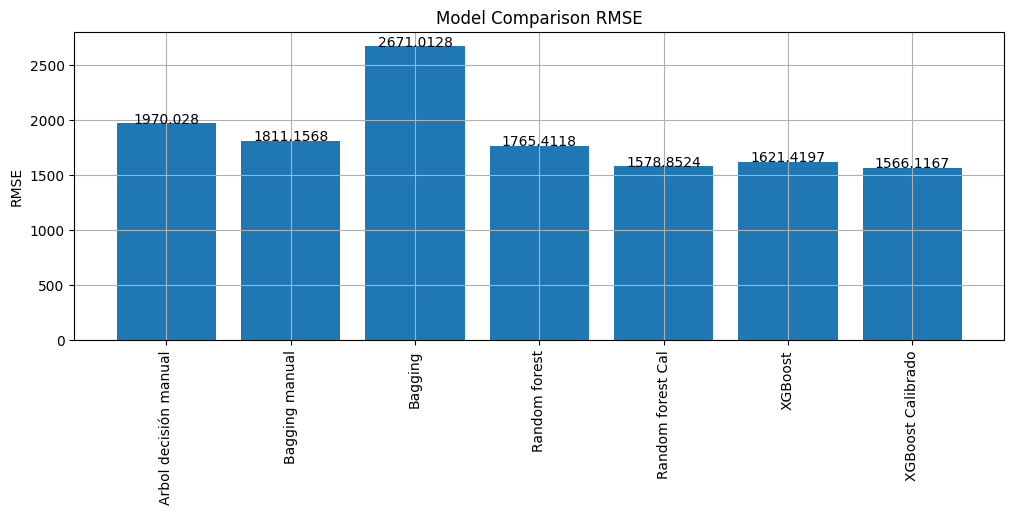

In [34]:
plt.figure(figsize=(12,4))
plt.bar(RMSE.keys(),RMSE.values() )
plt.ylabel('RMSE')
plt.title('Model Comparison RMSE')
plt.grid()
  
def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+ 0.002, round(y[i],4), ha = 'center')
        plt.xticks(rotation=90)

add_labels(RMSE.keys(),list(RMSE.values())) 

El modelo **XGBoost Calibrado** al contar con el valor del RMSE más bajo indica que el **modelo está produciendo predicciones más precisas y ajustadas del precio** 

Seguido por el modelo Random Forest Calibrado con un valor de 1.578. 


**Bagging por su parte es el modelo con el peor desempeño**, al contar con el RMSE más alto, esto indica que sus predicciones son menos precisas.

##Comparación del R2 - Devuelve la precisión del modelo

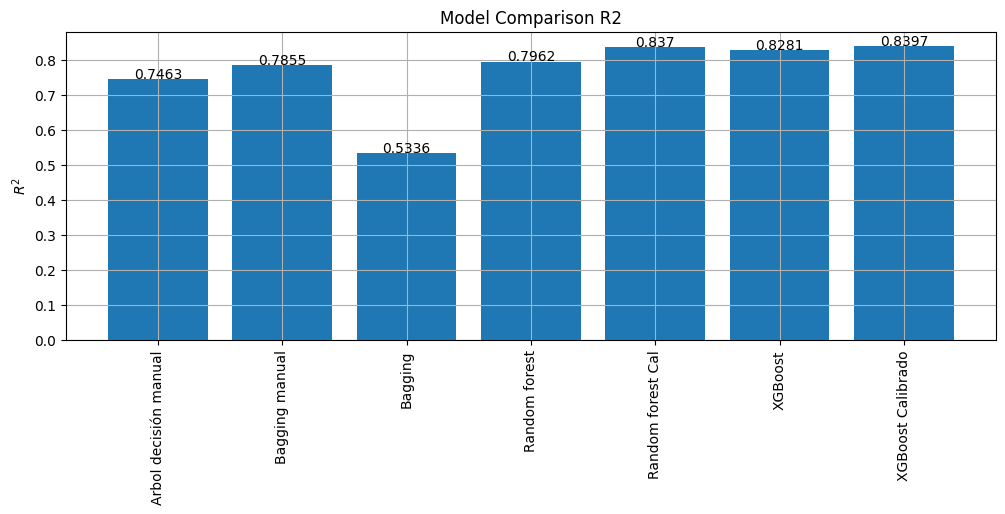

In [36]:
plt.figure(figsize=(12,4))
plt.bar(R2.keys(),R2.values() )
plt.ylabel('$R^2$')
plt.title('Model Comparison R2')
plt.grid()
  
def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+ 0.002, round(y[i],4), ha = 'center')
        plt.xticks(rotation=90)

add_labels(R2.keys(),list(R2.values())) 

Podemos evidenciar que el modelo con el mejor R2 es el **XGBoost Calibrado con 0.8397**, es decir, que este modelo explica en un 83% la variabilidad del precio

Sin embargo al evidenciar el desempeño de esta métrica con un modelo Random Forest, no cambia, lo que implica que no es tan bueno definir el desempeño de un modelo solo bajo esta métrica

##Comparación del MAPE - Error Porcentual Absoluto Medio ->se expresa como un porcentaje, y cuanto más cercano a cero sea el valor del MAPE, mayor será la precisión del modelo de predicción

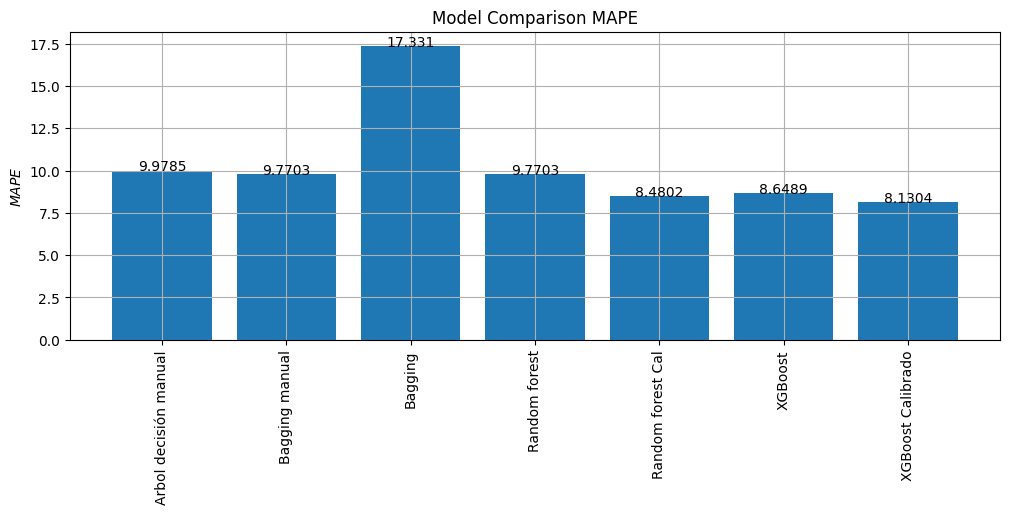

In [37]:
plt.figure(figsize=(12,4))
plt.bar(MAPE.keys(),MAPE.values() )
plt.ylabel('$MAPE$')
plt.title('Model Comparison MAPE')
plt.grid()
  
def add_labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+ 0.002, round(y[i],4), ha = 'center')
        plt.xticks(rotation=90)

add_labels(MAPE.keys(),list(MAPE.values())) 

En promedio con un modelo **XGBoost Calibrado** se tendría una desviación promedio del 8,1% en la predicción del precio. 
Sin embargo al no calibrar los parámetros del mismo modelo la proporción media MAPE aumenta a 8,6%. 

De igual manera para un modelo Random Rorest cuando se ajustan los parámetros, la métrica del MAPE mejora. 

Por su parte modelos como **Bagging y el arbol de decision son menos precisos** a la hora de predecir el precio, contando con proporciones mayores al 9%. 


## Conclusión Final

- A lo largo de todo el análisis siempre pudimos evidenciar el modelo con mejor desempeño a la hora de predecir el precio es el modelo **XGBoost Calibrado**, esto puede ser explicado porque es un modelo que utiliza regularización para evitar sobreajuste, proporcionando una mayor precisión por encima de otros modelos que en este caso fueron árbol de decisión, bagging e incluso Random Forest

- Los modelos de Random Forest calibrado y Xgboost calibrado son los que mejor se ajustan a los datos y tienen el menor MAPE, lo que sugiere que estos modelos pueden ser utilizados para predecir con mayor precisión el precio

- **El mejor modelo en términos de desempeño es el Xgb calibrado**, con un MAE de 1140.45, un RMSE de 1566.12, un R2 de 0.83965 y un MAPE de 8.13%. **Sus principales ventajas son**:

     *Es el modelo que obtiene la mayor precisión en las predicciones de   precios, con un MAE y un RMSE significativamente más bajos que los otros modelos.

    Tiene un R2 alto, lo que indica que se ajusta bien a los datos y es capaz de explicar la variabilidad en los precios de manera efectiva.

    Tiene un MAPE bajo, lo que significa que las predicciones del modelo tienen una diferencia proporcional baja en comparación con los precios reales

- **Las principales desventajas del modelo de Bagging con librería son**:

- Tiene un desempeño inferior en comparación con otros modelos, como el Random Forest con librería o el Xgboost calibrado, que tienen valores de métricas significativamente mejores.

- El valor de MAPE es alto, lo que sugiere que las predicciones del modelo tienen una diferencia proporcional alta en comparación con los precios reales.

- El valor de R2 es bajo, lo que indica que el modelo no se ajusta bien a los datos y no es capaz de explicar la variabilidad en los precios de manera efectiva.

- Debido a su baja precisión, este modelo puede no ser útil para tareas críticas que requieren predicciones precisas, como en finanzas o en la industria de bienes raíces